# Read output files

In [184]:
import awkward as ak
import numpy as np
import os, uproot, yaml
from glob import glob

In [185]:
source = 'glopart_v2'
base = f'/data/bond/fudawei/public/bbgamma_output/{source}'

filepath = {
    year: {
        #'data': sum([glob(f'{base}/data/{year}/{channel}/*') for channel in ['SingleMuon']], []),
    } for year in ['2016pre', '2016post', '2017', '2018']
}

BKG = set([k for k in filepath['2018'].keys()]) - set(['data'])

for year in filepath:
    for job_dir in sum([glob(f'{base}/mc/{year}/{channel}/*') for channel in ['ZpToHG', 'GluGluToZG']], []):
        mass = job_dir.split('M')[1].replace('_0p014', '')
        filepath[year][mass+r'$\to$'+('H' if 'ZpToHG' in job_dir else 'Z')+r'$\gamma$'] = [job_dir]

events = {year: {k: [] for k in filepath[year]} for year in filepath}

for year in filepath:
    for channel, folders in filepath[year].items():
        for folder in folders:
            mode = '_'.join(folder.split('/')[-4:-1])
            if len(os.listdir(folder)) != 2:
                continue
            if os.path.exists(os.path.join(folder, f'{mode}.parq')):
                os.rename(os.path.join(folder, f'{mode}.parq'), os.path.join(folder, f'{mode}.parquet'))
            folder_events = ak.from_parquet(os.path.join(folder, f'{mode}.parquet'))
            with open(os.path.join(folder, f'{mode}.yaml'), 'r', encoding='utf-8') as f:
                folder_stats = yaml.safe_load(f)
            if 'mc' in mode and ak.mean(folder_events.event_final_weight) > np.sqrt(folder_stats['final']):
                test_events = folder_events
                continue

            events[year][channel].append(folder_events)

        if len(events[year][channel]) == 0:
            del events[year][channel]
        else:
            events[year][channel] = ak.concatenate(events[year][channel], axis=0)

In [186]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$H(cc)$\gamma$': 'green',
    r'1000$\to$Z(bb)$\gamma$': 'blue',
    r'2000$\to$H(bb)$\gamma$': 'gold',
    #r'2000$\to$H(cc)$\gamma$': 'darkorange',
    r'2000$\to$Z(bb)$\gamma$': 'cyan',
    #r'3000$\to$H(bb)$\gamma$': 'gold',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

In [187]:
def decomposite(signal: ak.Array):
    HWW_decay_mode = ak.fill_none(signal.gen_HWW_decay_mode, 0)

    signal['HWW_4q'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode >= 32)

    signal['HWW_qqlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode > 16) & (HWW_decay_mode < 32)
    
    signal['HWW_lvlv'] = signal['gen_ZpToH(WW)Gamma'] & (HWW_decay_mode <= 16)
    
    return signal

DECOMPOSITE = True
if DECOMPOSITE:
    for y in events:
        for c in list(events[y].keys()):
            if c in BKG or c=='data':
                continue
            if 'H' in c:
                events[y][c.replace('H', 'H(bb)')] = events[y][c][events[y][c]['gen_ZpToH(bb)Gamma']]
            if 'Z' in c:
                events[y][c.replace('Z', 'Z(bb)')] = events[y][c][events[y][c]['gen_GluGluToZ(bb)Gamma']]


In [188]:
weight={
    y: {
        c: (events[y][c].event_final_weight if c!='data' else ak.ones_like(events[y][c]['photon_pt'])) for c in events[y] 
    } for y in events
}


weight['Run2'] = {k: ak.concatenate([weight[y][k] for y in weight if k in weight[y] and y.startswith('201')], axis=0) for k in weight['2018']}
events['Run2'] = {k: ak.concatenate([events[y][k] for y in events if k in events[y] and y.startswith('201')], axis=0) for k in events['2018']}

# Start plotting

In [189]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])

    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

# Uncertainty

In [190]:
systematics = {
    'lumi_Run2': 1.016,
    'L1_prefiring': 1.004,
    'pile-up': 1.01,
    'HLT_efficiency': 1.01,
    'photon_ID': 1.044,
    'CSEV': 1.001,
    'PES': 1.007,
    'PER': 1.008,
    'Br_Hbb': '0.9874/1.0124',
    'BR_Zbb': 1.003
}

In [ ]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def uncertainty_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min)/bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    ratio = {}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        
        if weight is not None:
            hist.fill(v, weight=weight[k])
        else:
            hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var

    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    err_nominal = error_bar(individual['h']['nominal'], individual['var']['nominal'], mode='mc')
    h_nominal = individual['h']['nominal']
    for (k, h) in individual['h'].items():
        if k == 'nominal':
            continue
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%(np.sum(h)/np.sum(h_nominal)), histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio[k] = h / individual['h']['nominal']
        #ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
        hep.histplot(ratio[k], bins=hist.axes[0].edges, yerr=0, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(h_nominal, bins=hist.axes[0].edges, yerr=err_nominal, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(ax1.get_ylim()[0]*1.2-0.2, ax1.get_ylim()[1]*1.2-0.2)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

    return np.nanmax(ratio['up']), np.nanmin(ratio['down'])

In [103]:
def variation_plot(arrays, plot_name: str, x_name: str, year='Run2', x_min=500, x_max=4000, y_min=-0.05, y_max=0.05):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))

    ## canvas initializing
    f = plt.figure(figsize=(9, 3))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')

    ## plot
    for k in arrays:
        ax.scatter(list(arrays[k].keys()), list(arrays[k].values()), label=k)

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylabel('Variation', fontsize=20, ha='right', y=1)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=16)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

### L1 prefiring

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger'] < 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger'] < 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays_ = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays_, plot_name='L1_prefiring_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger'] < 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger'] > 0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['L1PreFiringWeight_Up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['L1PreFiringWeight_Nom'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['L1PreFiringWeight_Dn'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'L1_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='L1_prefiring_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

## CSEV

### SR1

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR1', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

### SR2

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['photon_CSEV_SF_up'])[eval(cut)],
        'nominal': (weight[y][k]*events[y][k]['photon_CSEV_SF_nominal'])[eval(cut)],
        'down': (weight[y][k]*events[y][k]['photon_CSEV_SF_down'])[eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    fit_variable = events[y][k]['photon+jet_mass'][eval(cut)]
    ratio['up'][m], ratio['down'][m] = uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: L1 prefiring', plot_name=f'CSEV_{m}_SR2', x_min=m-3*np.std(fit_variable), x_max=m+3*np.std(fit_variable), bin_width=50, weight=_weight, year=y, y_min=0.99, y_max=1.01)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='CSEV_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

## Photon ID SF

In [ ]:
from matplotlib.cm import get_cmap
from cycler import cycler

hep.style.use("CMS")
mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab10").colors)

def SF_plot(arrays, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min) / bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = f.add_subplot(gs[0])
    ax.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}, 'err': {}}
    
    for (k, v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
        if weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        individual['h'][k] = h
        individual['var'][k] = var
        individual['err'][k] = error_bar(individual['h'][k], individual['var'][k], mode='mc')

    ## plot
    ax.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')

    ratio = {}
    for (k, h) in individual['h'].items():
        if 'w/o' not in k:
            ratio[k] = individual['h'][k] / individual['h']['w/o SF']
    SF = np.sum(individual['h']['SF_nominal'])/np.sum(individual['h']['w/o SF'])

    k = 'photon ID SF'
    hep.histplot(ratio['SF_nominal'], bins=hist.axes[0].edges, yerr=[ratio['SF_nominal']-ratio['SF_down'], ratio['SF_up']-ratio['SF_nominal']], histtype='errorbar', density=False, stack=False, ax=ax, label=f'{k}: %.3f'%SF)

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_ylim(y_min, y_max)
    ax.set_ylabel('ratio', ha='right', fontsize=20, y=1)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')

In [ ]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.8) & 
        (JES_Hbb[y][k]<0.96) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 105) & 
        (events[y][k]['AK8jet_particleNet_mass] < 145)
    )"""
    _weight = {
        'SF_nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'SF_up': events[y][k]['photon_SF_up'][eval(cut)],
        'SF_down': events[y][k]['photon_SF_down'][eval(cut)],
        'w/o SF': ak.ones_like(events[y][k]['photon_SF_nominal'][eval(cut)]),
    }
    arrays={
        i: events[y][k]['photon_pt'][eval(cut)] for i in _weight
    }
    SF_plot(arrays, x_name=r'$p_T(\gamma)$ [GeV]', plot_name=f'photon_SF_m{m}_SR1', x_min=int(m)/2-500, x_max=int(m), bin_width=100, weight=_weight, year=y, y_min=0.95, y_max=1.05)
    
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.96) &
        (events[y][k]['AK8jet_particleNet_mass'] > 105) & 
        (events[y][k]['AK8jet_particleNet_mass] < 145)
    )"""
    _weight = {
        'SF_nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'SF_up': events[y][k]['photon_SF_up'][eval(cut)],
        'SF_down': events[y][k]['photon_SF_down'][eval(cut)],
        'w/o SF': ak.ones_like(events[y][k]['photon_SF_nominal'][eval(cut)]),
    }
    arrays={
        i: events[y][k]['photon_pt'][eval(cut)] for i in _weight
    }
    SF_plot(arrays, x_name=r'$p_T(\gamma)$ [GeV]', plot_name=f'photon_SF_m{m}_SR2', x_min=int(m)/2-500, x_max=int(m), bin_width=100, weight=_weight, year=y, y_min=0.95, y_max=1.05)

### uncertainty

In [ ]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.7) & 
        (tagger_Hbb[y][k]<0.9) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 145)
    )"""
    _weight = {
        'up': events[y][k]['photon_SF_up'][eval(cut)],
        'nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'down': events[y][k]['photon_SF_down'][eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: photon ID', plot_name=f'photon_ID_m{m}_SR1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.95, y_max=1.05)
    
y='Run2'
for m in ('1000', '2000', '3000'):
    k=r'$Z^\mathrm{\prime}$('+ m + r')$\to H(bb)\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (tagger_Hbb[y][k]>0.9) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 145)
    )"""
    
    
    _weight = {
        'up': events[y][k]['photon_SF_up'][eval(cut)],
        'nominal': events[y][k]['photon_SF_nominal'][eval(cut)],
        'down': events[y][k]['photon_SF_down'][eval(cut)]
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: photon ID', plot_name=f'photon_ID_m{m}_SR2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y, y_min=0.95, y_max=1.05)

## Tagger

In [191]:
systematics['Xbb_tagger'] = {
    'SR1': {},
    'SR2': {}
}

### SR1

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.066/1.010+((jet_pt>400)&(jet_pt<600))*0.054/1.035+(jet_pt>600)*0.034/0.988)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.066/1.010+((jet_pt>400)&(jet_pt<600))*0.053/1.035+(jet_pt>600)*0.034/0.988)
    systematics['Xbb_tagger']['SR1'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='tagger_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.066/1.010+((jet_pt>400)&(jet_pt<600))*0.054/1.035+(jet_pt>600)*0.034/0.988)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.066/1.010+((jet_pt>400)&(jet_pt<600))*0.053/1.035+(jet_pt>600)*0.034/0.988)

variation_plot(arrays=arrays, plot_name='tagger_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.066/1.010+((jet_pt>400)&(jet_pt<600))*0.054/1.035+(jet_pt>600)*0.034/0.988)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.066/1.010+((jet_pt>400)&(jet_pt<600))*0.053/1.035+(jet_pt>600)*0.034/0.988)

variation_plot(arrays=arrays, plot_name='tagger_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

### SR2

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.051/1.018+(jet_pt>600)*0.060/1.054)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.053/1.018+(jet_pt>600)*0.056/1.054)
    systematics['Xbb_tagger']['SR2'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='tagger_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.15, y_max=0.15)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.051/1.018+(jet_pt>600)*0.060/1.054)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.053/1.018+(jet_pt>600)*0.056/1.054)

variation_plot(arrays=arrays, plot_name='tagger_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.15, y_max=0.15)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.051/1.018+(jet_pt>600)*0.060/1.054)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.053/1.018+(jet_pt>600)*0.056/1.054)

variation_plot(arrays=arrays, plot_name='tagger_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.15, y_max=0.15)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    cut = """(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110)
    )"""
    jet_pt = events[y][k]['AK8jet_pt'][eval(cut)]
    
    arrays['up'][m] = ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.051/1.018+(jet_pt>600)*0.060/1.054)
    arrays['down'][m] = -ak.mean((jet_pt<400)*0.112/1.075+((jet_pt>400)&(jet_pt<600))*0.053/1.018+(jet_pt>600)*0.056/1.054)

variation_plot(arrays=arrays, plot_name='tagger_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.15, y_max=0.15)

## PES

In [199]:
systematics['PES'] = {
    'SR1': {},
    'SR2': {}
}

### SR1

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    systematics['PES']['SR1'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

### SR2

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1
    systematics['PES']['SR2'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PES_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PES_down'][eval(cut)]
    }
    
    variation['up'][m] = np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1)
    variation['down'][m] = np.mean(arrays['down'])/np.mean(arrays['nominal'])-1

variation_plot(arrays=variation, plot_name='PES_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

## PER

### SR1

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007
    systematics['PER']['SR1'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = (variation['down'][800]+variation['down'][1000])/2

variation_plot(arrays=variation, plot_name='PER_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.01
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.01

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = (variation['down'][800]+variation['down'][1000])/2

variation_plot(arrays=variation, plot_name='PER_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.005, y_max=0.005)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.sqrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.01
    variation['down'][m] = -np.sqrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.01

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = (variation['down'][800]+variation['down'][1000])/2

variation_plot(arrays=variation, plot_name='PER_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.005, y_max=0.005)

### SR2

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007
    systematics['PER']['SR2'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='PER_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.007
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.007

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = (variation['down'][800]+variation['down'][1000])/2

variation_plot(arrays=variation, plot_name='PER_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.01, y_max=0.01)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.cbrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.01
    variation['down'][m] = -np.cbrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.01

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = (variation['down'][800]+variation['down'][1000])/2

variation_plot(arrays=variation, plot_name='PER_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.005, y_max=0.005)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_PER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_PER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.sqrt(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1))*0.01
    variation['down'][m] = -np.sqrt(np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))*0.01

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = (variation['down'][800]+variation['down'][1000])/2

variation_plot(arrays=variation, plot_name='PER_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.005, y_max=0.005)

## JES

In [211]:
systematics['JES'] = {'SR1': {}, 'SR2': {}}

### SR1

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    systematics['JES']['SR1'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation_plot(arrays=variation, plot_name='JES_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation_plot(arrays=variation, plot_name='JES_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation_plot(arrays=variation, plot_name='JES_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

### SR2

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]
    systematics['JES']['SR2'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JES_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation_plot(arrays=variation, plot_name='JES_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation_plot(arrays=variation, plot_name='JES_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

In [ ]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JES_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JES_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.mean(arrays['up'])/np.mean(arrays['nominal'])-1), np.abs(np.mean(arrays['down'])/np.mean(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation_plot(arrays=variation, plot_name='JES_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

## JER

In [221]:
systematics['JER'] = {
    'SR1': {
        'H': {},
        'Z': {},
    },
    'SR2': {
        'H': {},
        'Z': {},
    }
}

### SR1

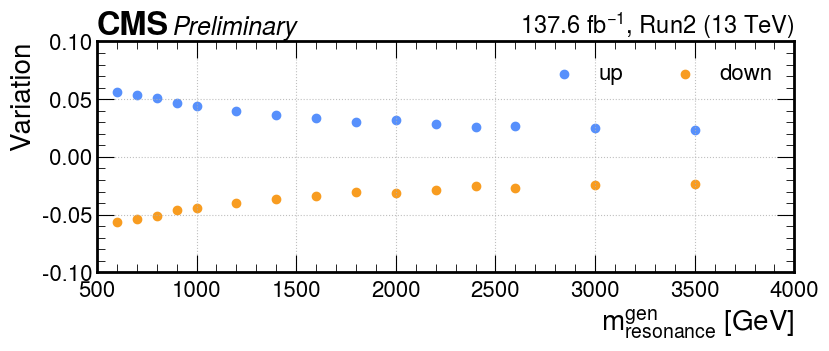

In [222]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))/2
    variation['down'][m] = -variation['up'][m]
    systematics['JER']['SR1']['H'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

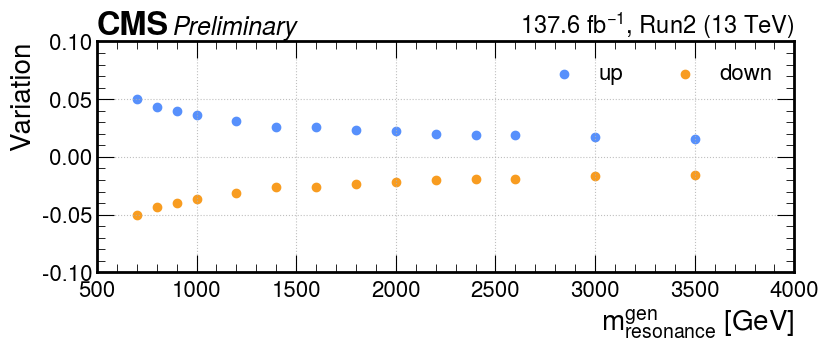

In [223]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))/2
    variation['down'][m] = -variation['up'][m]

variation['up'][700] = 0.050
variation['down'][700] = -variation['up'][700]
variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = -variation['up'][900]
for m in variation['up']:
    systematics['JER']['SR1']['Z'][m] = float(1+round(variation['up'][m], 3))
variation_plot(arrays=variation, plot_name='JER_Z_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

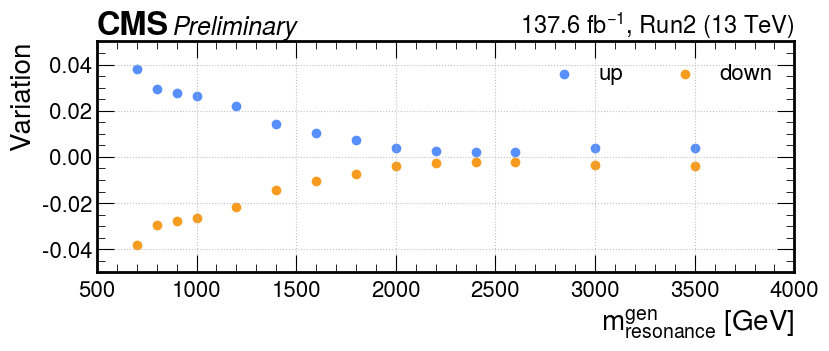

In [224]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean([np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1)])
    variation['down'][m] = -variation['up'][m]

variation['up'][700] = 0.038
variation['down'][700] = -variation['up'][700]
variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = -variation['up'][900]
for m in variation['up']:
    systematics['JER']['SR1']['Z'][f'{m}_5p6'] = float(1+round(variation['up'][m], 3))
variation_plot(arrays=variation, plot_name='JER_Z_5p6_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

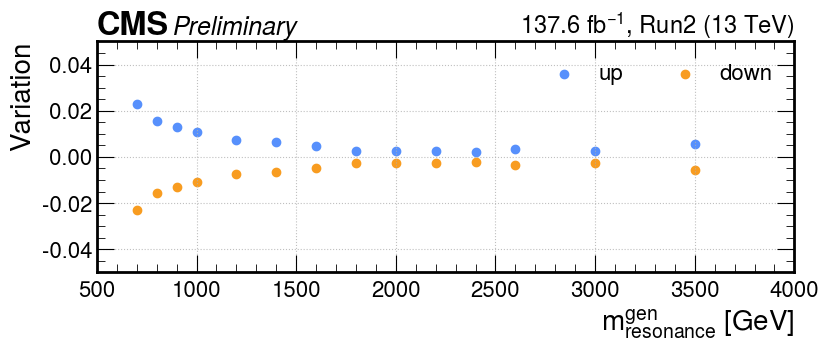

In [225]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = np.mean([np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1)])
    variation['down'][m] = -variation['up'][m]

variation['up'][700] = 0.023
variation['down'][700] = -variation['up'][700]
variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = -variation['up'][900]
for m in variation['up']:
    systematics['JER']['SR1']['Z'][f'{m}_10p0'] = float(1+round(variation['up'][m], 3))
variation_plot(arrays=variation, plot_name='JER_Z_10p0_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

### SR2

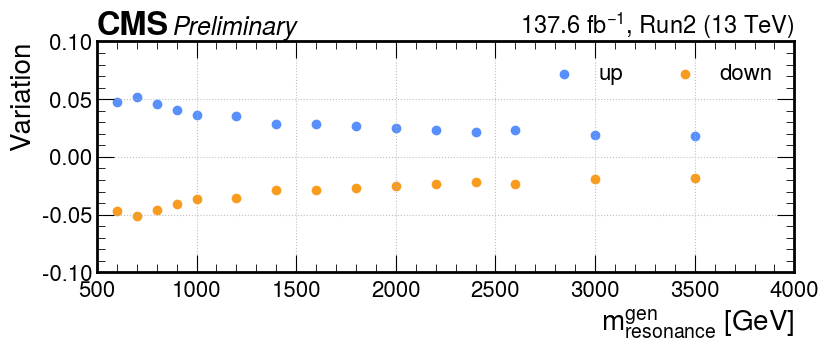

In [226]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))/2
    variation['down'][m] = -variation['up'][m]
    systematics['JER']['SR2']['H'][m] = float(1+round(variation['up'][m], 3))

variation_plot(arrays=variation, plot_name='JER_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

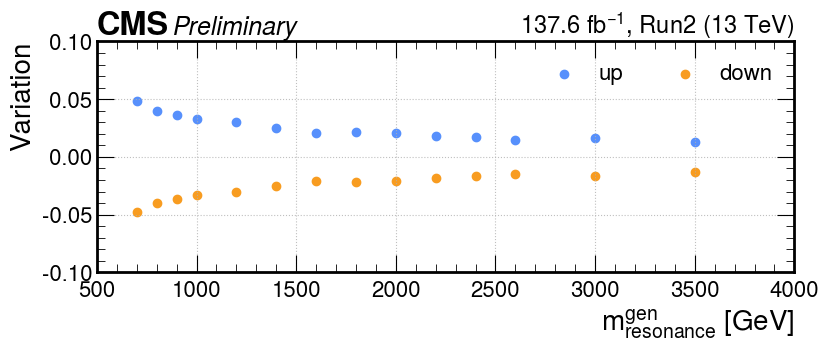

In [227]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_' in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))/2
    variation['down'][m] = -variation['up'][m]

variation['up'][700] = 0.048
variation['down'][700] = -variation['up'][700]
variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = -variation['up'][900]
for m in variation['up']:
    systematics['JER']['SR2']['Z'][m] = float(1+round(variation['up'][m], 3))
variation_plot(arrays=variation, plot_name='JER_Z_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.1, y_max=0.1)

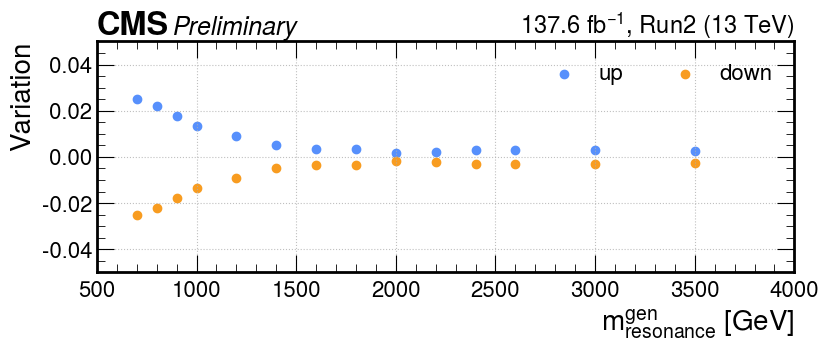

In [228]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_5p6' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation['up'][700] = 0.025
variation['down'][700] = -variation['up'][700]
variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = -variation['up'][900]
variation['up'][1600] = (variation['up'][1400]+variation['up'][2000])/2
variation['down'][1600] = -variation['up'][1600]
variation['up'][1800] = variation['up'][1600]
variation['down'][1800] = -variation['up'][1800]
for m in variation['up']:
    systematics['JER']['SR2']['Z'][f'{m}_5p6'] = float(1+round(variation['up'][m], 3))
variation_plot(arrays=variation, plot_name='JER_Z_5p6_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.05, y_max=0.05)

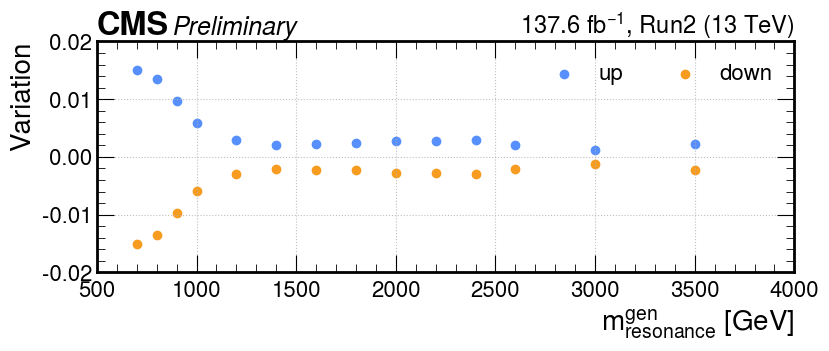

In [229]:
y='Run2'

arrays = {'up': {}, 'down': {}}
variation = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'Z(bb)' not in k or '_10p0' not in k:
        continue
    m = int(k.split('_')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 80) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 110) &
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    arrays={
        'up': events[y][k]['photon+jet_mass_JER_up'][eval(cut)],
        'nominal': events[y][k]['photon+jet_mass'][eval(cut)],
        'down': events[y][k]['photon+jet_mass_JER_down'][eval(cut)]
    }
    
    variation['up'][m] = min(np.abs(np.std(arrays['up'])/np.std(arrays['nominal'])-1), np.abs(np.std(arrays['down'])/np.std(arrays['nominal'])-1))
    variation['down'][m] = -variation['up'][m]

variation['up'][700] = 0.015
variation['down'][700] = -variation['up'][700]

variation['up'][900] = (variation['up'][800]+variation['up'][1000])/2
variation['down'][900] = -variation['up'][900]
variation['up'][1200] = (variation['up'][1000]+variation['up'][1400])/2
variation['down'][1200] = -variation['up'][1200]
variation['up'][1400] = (variation['up'][1200]+variation['up'][1600])/2
variation['down'][1400] = -variation['up'][1400]
variation['up'][1600] = (variation['up'][1400]+variation['up'][1800])/2
variation['down'][1600] = -variation['up'][1600]
variation['up'][2600] = (variation['up'][2400]+variation['up'][3000])/2
variation['down'][2600] = -variation['up'][2600]
for m in variation['up']:
    systematics['JER']['SR2']['Z'][f'{m}_10p0'] = float(1+round(variation['up'][m], 3))
variation_plot(arrays=variation, plot_name='JER_Z_10p0_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.02, y_max=0.02)

## QCD Scale

In [230]:
systematics['QCD_scale'] = {
    'SR1': {},
    'SR2': {}
}

In [ ]:
y='Run2'
for m in ('700', '3500'):
    k = m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.8) & 
        (events[y][k].AK8jet_Xbb_tagger<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0]),
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1]),
        #r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2]),
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3]),
        'nominal': weight[y][k],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4]),
        #r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5]),
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6]),
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7]),
    }
    arrays={
        i: events[y][k]['photon+jet_mass'] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'QCD_scales_{m}_SRH1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y)
    
y='Run2'
for m in ('700', '3500'):
    k = m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    
    
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0]),
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1]),
        #r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2]),
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3]),
        'nominal': weight[y][k],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4]),
        #r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5]),
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6]),
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7]),
    }
    arrays={
        i: events[y][k]['photon+jet_mass'] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'QCD_scales_{m}_SRH2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y)

In [ ]:
y='Run2'
for m in ('1000', '2000', '3500'):
    k = m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.8) & 
        (events[y][k].AK8jet_Xbb_tagger<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$', plot_name=f'QCD_scales_{m}_SRH1', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y)
    
y='Run2'
for m in ('1000', '2000', '3500'):
    k = m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    
    
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$', plot_name=f'QCD_scales_{m}_SRH2', x_min=int(m)*0.7, x_max=int(m)*1.3, bins=20, weight=_weight, year=y)

### SR1

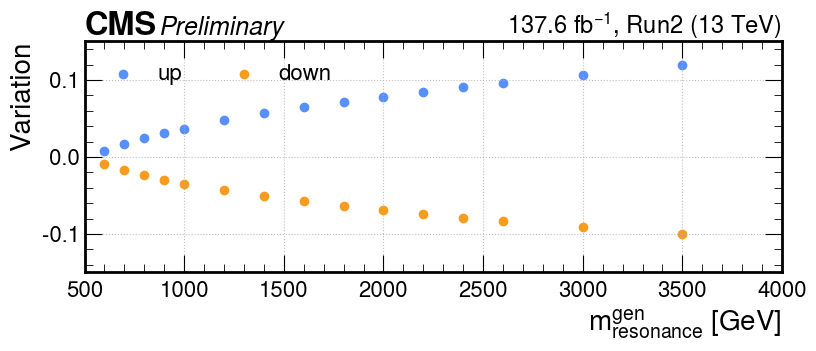

In [231]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) & 
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    ratio['up'][m] = np.max([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    ratio['down'][m] = np.min([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    systematics['QCD_scale']['SR1'][m] = round(float(ratio['up'][m]),3)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='QCD_scale_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.15, y_max=0.15)

### SR2

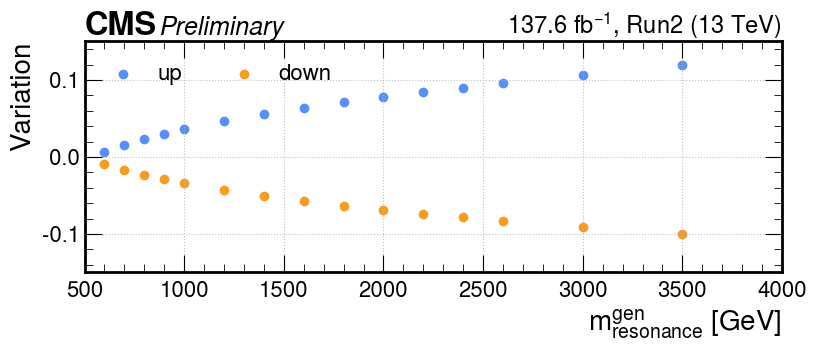

In [232]:
y='Run2'

ratio = {'up': {}, 'down': {}}

for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])
    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) & 
        (events[y][k]['photon+jet_mass'] > {m} - 3*{mass_widow}) & 
        (events[y][k]['photon+jet_mass'] < {m} + 3*{mass_widow})
    )"""
    _weight = {
        r'$\mu_R$=0.5, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 0])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 1])[eval(cut)],
        r'$\mu_R$=0.5, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 2])[eval(cut)],
        r'$\mu_R$=1, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 3])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        r'$\mu_R$=1, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 4])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=0.5': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 5])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=1': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 6])[eval(cut)],
        r'$\mu_R$=2, $\mu_F$=2': (weight[y][k]*events[y][k]['LHEScaleWeight'][:, 7])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    ratio['up'][m] = np.max([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    ratio['down'][m] = np.min([np.sum(_weight[i])/np.sum(_weight['nominal']) for i in _weight])
    systematics['QCD_scale']['SR2'][m] = round(float(ratio['up'][m]),3)
    
arrays = {
    'up': {m: ratio['up'][m]-1 for m in ratio['up']},
    'down': {m: ratio['down'][m]-1 for m in ratio['down']},
}

variation_plot(arrays=arrays, plot_name='QCD_scale_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.15, y_max=0.15)

## PDF

In [233]:
systematics['PDF'] = {
    'SR1': {},
    'SR2': {}
}

In [234]:
def pdf_uncertainty_plot(array, weight, plot_name: str, x_name: str, year='2018', bins=None, bin_width=None, x_min=0, x_max=2000, overflow=True, underflow=False, log_y=False, x_axis=None, y_min=0.5, y_max=1.5):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = int((x_max-x_min)/bin_width)
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')


    ## analyze
    individual = {'h': {}, 'var': {}}
    ratio = {}
    hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
    hist.fill(array, weight=_weight[:, 0])
    h, var = flow(hist=hist, overflow=False, underflow=False)
    arrays = {'nominal': h}
    
    histogram = {}
    bins = int((x_max-x_min)/bin_width)
    for i in range(len(_weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array, weight=_weight[:, i])
        h, var = flow(hist=hist, overflow=False, underflow=False)
        histogram[i]=h
    h_var = np.sqrt(np.sum([(histogram[i]-histogram[0])**2 for i in histogram if i!=0], axis=0))/1.5
    arrays['up'] = arrays['nominal']  + h_var
    arrays['down'] = arrays['nominal']  - h_var
    
    for (k, v) in arrays.items():
        individual['h'][k] = v
        individual['var'][k] = np.sqrt(v)

    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    #COLOR = {'nominal': 'blue', 'up': 'red', 'down': 'green'}
    err_nominal = error_bar(individual['h']['nominal'], individual['var']['nominal'], mode='mc')
    h_nominal = individual['h']['nominal']
    for (k, h) in individual['h'].items():
        if k == 'nominal':
            continue
        err = error_bar(h, individual['var'][k], mode='mc')
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=f'{k}: %.3f'%(np.sum(h)/np.sum(h_nominal)), histtype='step', density=False, stack=False, linewidth=2, ax=ax)
        ratio[k] = h / individual['h']['nominal']
        #ratio_err = ratio * np.sqrt((err/h)**2 + (err_nominal/individual['h']['nominal'])**2)
        hep.histplot(ratio[k], bins=hist.axes[0].edges, yerr=0, histtype='errorbar', density=False, stack=False, ax=ax1)
    hep.histplot(h_nominal, bins=hist.axes[0].edges, yerr=err_nominal, label='nominal: 1', histtype='step', density=False, stack=False, linewidth=2, ax=ax)


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax1.set_ylim(np.sum(arrays['down'])/np.sum(h_nominal)*2-1, np.sum(arrays['up'])/np.sum(h_nominal)*2-1)
    ax1.set_ylabel('ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=15)

    ## finalizing
    if not os.path.exists(f'./plots/uncertainty/{year}'):
        os.makedirs(f'./plots/uncertainty/{year}')
    plt.savefig(f"./plots/uncertainty/{year}/{plot_name}.pdf", bbox_inches='tight')

    #return np.nanmax(ratio['up']), np.nanmin(ratio['down'])

In [ ]:
y='Run2'
for m in ('700', '3500'):
    k = m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.8) & 
        (events[y][k].AK8jet_Xbb_tagger<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = (events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    pdf_uncertainty_plot(array, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'QCD_scales_{m}_SRH1', x_min=int(m)-100*round(np.sqrt(int(m)/100),0), x_max=int(m)+100*round(np.sqrt(int(m)/100), 0), bin_width=50, weight=_weight, year=y)
    
y='Run2'
for m in ('700', '3500'):
    k = m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k].AK8jet_Xbb_tagger>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    
    _weight = (events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    pdf_uncertainty_plot(array, x_name=r'$m_{j\gamma}$ [GeV]', plot_name=f'QCD_scales_{m}_SRH2', x_min=int(m)-100*round(np.sqrt(int(m)/100), 0), x_max=int(m)+100*round(np.sqrt(int(m)/100), 0), bin_width=50, weight=_weight, year=y)

### SR1

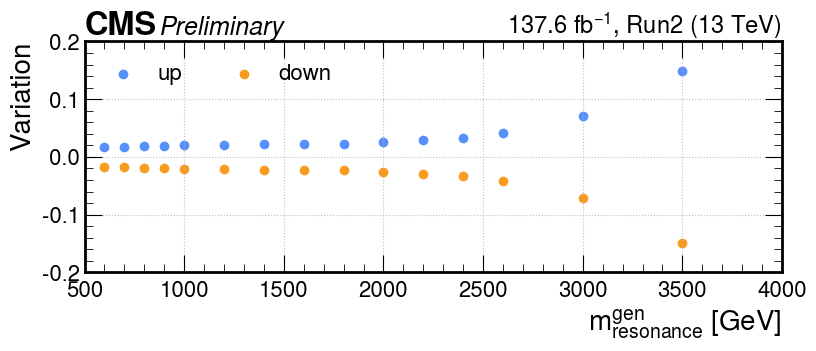

In [235]:
y='Run2'

arrays = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])

    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m}-3*{mass_widow}) &
        (events[y][k]['photon+jet_mass'] < {m}+3*{mass_widow})
    )"""
    _weight = (weight[y][k]*events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    
    bin_width = 50
    x_max = m+3*mass_widow
    x_min = m-3*mass_widow
    
    histogram = {}
    bins = int((x_max-x_min)/bin_width)
    for i in range(len(_weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array, weight=_weight[:, i])
        h, var = flow(hist=hist, overflow=False, underflow=False)
        histogram[i]=h
    h_var = np.sqrt(np.sum([(histogram[i]-histogram[0])**2 for i in histogram if i!=0], axis=0))
    arrays['up'][m] = np.sum(h_var)/np.sum(histogram[0])
    arrays['up'][m] = arrays['up'][m]/1.5
    arrays['down'][m] = -arrays['up'][m]
    systematics['PDF']['SR1'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='PDF_H_SR1', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.2, y_max=0.2)

### SR2

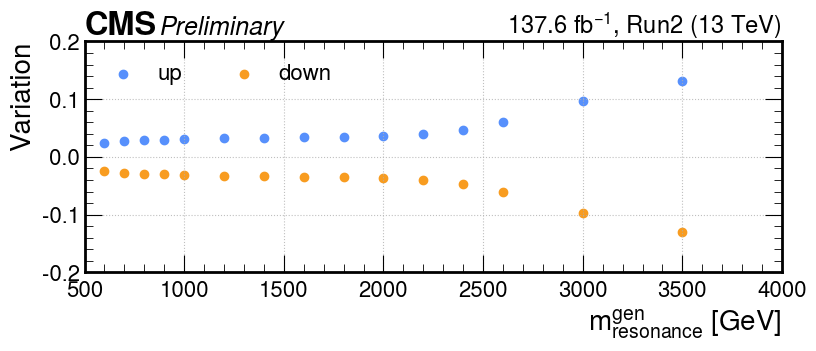

In [236]:
y='Run2'

arrays = {'up': {}, 'down': {}}
for k in events['Run2']:
    if 'H(bb)' not in k:
        continue
    m = int(k.split('$')[0])

    mass_widow = np.std(events[y][k]['photon+jet_mass'])
    cut = f"""(
        (events[y][k]['photon-jet_deltaR'] > 1.1) &
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.98) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150) &
        (events[y][k]['photon+jet_mass'] > {m}-3*{mass_widow}) &
        (events[y][k]['photon+jet_mass'] < {m}+3*{mass_widow})
    )"""
    _weight = (weight[y][k]*events[y][k]['LHEPdfWeight'])[eval(cut)]
    array = events[y][k]['photon+jet_mass'][eval(cut)]
    
    bin_width = 50
    x_max = m+3*mass_widow
    x_min = m-3*mass_widow
    
    histogram = {}
    bins = int((x_max-x_min)/bin_width)
    for i in range(len(_weight[0])):
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(array, weight=_weight[:, i])
        h, var = flow(hist=hist, overflow=False, underflow=False)
        histogram[i]=h
    h_var = np.sqrt(np.sum([(histogram[i]-histogram[0])**2 for i in histogram if i!=0], axis=0))
    arrays['up'][m] = np.sum(h_var)/np.sum(histogram[0])
    if arrays['up'][m] > 0.1:
        arrays['up'][m] = arrays['up'][m]/1.5
    arrays['down'][m] = -arrays['up'][m]
    systematics['PDF']['SR2'][m] = float(1+round(arrays['up'][m], 3))

variation_plot(arrays=arrays, plot_name='PDF_H_SR2', x_name=r'$m^{gen}_{resonance}$ [GeV]', y_min=-0.2, y_max=0.2)

## Trigger Efficiency

In [160]:
SIG_COLOR = {
    #r'700$\to$H(bb)$\gamma$': 'cyan',
    r'1000$\to$H(bb)$\gamma$': 'red',
    #r'1000$\to$Z(bb)$\gamma$': 'blue',
    r'2000$\to$H(bb)$\gamma$': 'blue',
    #r'2000$\to$Z(bb)$\gamma$': 'cyan',
    r'3000$\to$H(bb)$\gamma$': 'yellow',
    #r'3000$\to$Z(bb)$\gamma$': 'BlueViolet',
}

hep.style.use("CMS")

def trigger_efficiency_plot(arrays, triggered, weight, plot_name: str, x_name: str, year='Run2', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, x_axis=None, bin_width=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    if bin_width is not None:
        bins = (x_max - x_min) // bin_width

    ## canvas initializing
    f = plt.figure(figsize=(9, 9))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.1)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=False, year=year, ax=ax, lumi=round(LUMI[year], 1), fontsize=18, llabel='Preliminary')

    ## analyze
    histogram = {'raw':{}, 'triggered': {}}
    h_err = {'raw':{}, 'triggered': {}}
    efficiency = {}
    eff_err = {}
    ratio_err = {}

    for (k, v) in arrays.items():
        for mode in ('raw', 'triggered'):
            if x_axis is None:
                hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
            else:
                hist = bh.Histogram(x_axis, storage=bh.storage.Weight())

            v = (v if mode=='raw' else v[triggered[k]==1])
            w = (weight[k] if mode=='raw' else weight[k][triggered[k]==1])
            hist.fill(v, weight=w)
            h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
            histogram[mode][k] = h
            h_err[mode][k] = error_bar(histogram[mode][k], var, mode=('data' if k=='data' else 'mc'))

    eff_err_custom = {}
    for k in histogram['raw']:
        efficiency[k] = histogram['triggered'][k]/histogram['raw'][k]
        eff_err[k] = h_err['raw'][k] / histogram['raw'][k]
        eff_err_custom[k] = np.copy(eff_err[k])
        eff_err_custom[k][1] = np.min([1-efficiency[k], eff_err_custom[k][1]], axis=0)

    ## plot
    for (k, eff) in efficiency.items():
        if k != 'data':
            hep.histplot(eff, bins=hist.axes[0].edges, xerr=True, yerr=eff_err[k], label=k, histtype='errorbar', density=density, markersize=5, stack=False, linewidth=2, ax=ax, capsize=4)
            ratio = efficiency['data']/eff
            ratio_err[k] = ratio * np.sqrt((eff_err['data']/efficiency['data'])**2)
            hep.histplot(ratio, bins=hist.axes[0].edges, xerr=True, yerr=ratio_err[k], label=k, histtype='errorbar', markersize=5, density=density, stack=False, linewidth=2, ax=ax1, capsize=4)
        else:
            hep.histplot(eff, bins=hist.axes[0].edges, xerr=True, yerr=eff_err[k], label=k, histtype='errorbar', density=density, markersize=10, stack=False, linewidth=2, ax=ax, color='black', capsize=4)
    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0.6, 1.2)
    ax.set_xticklabels([])
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    ax.set_ylabel(r'$\varepsilon_{trigger}$', fontsize=22, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    ax1.set_ylim(0.8, 1.2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_ylabel(r'SF=$\frac{\varepsilon(data)}{\varepsilon(MC)}$', fontsize=22, ha='right', y=1)

    ## title, text and legend
    ax.legend(loc="best", ncol=1, frameon=False, fontsize=18)

    ## finalizing
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}.pdf", bbox_inches='tight')
    plt.show()
    
    return ratio_err

In [ ]:
y = 'Run2'
arrays = {}
triggered = {}
for k in list(SIG_COLOR.keys())+['data']:
    arrays[k] = events[y][k]['photon_pt']
    if k == 'data':
        triggered[k] = events[y][k]['triggered'] | (np.abs(events[y][k]['photon_eta'])<1.4442)
    else:
        triggered[k] = events[y][k]['triggered'] | (np.abs(events[y][k]['photon_eta'])<1.4442)

SF_err = trigger_efficiency_plot(arrays, triggered, x_name=r'$p_T(\gamma)$', plot_name=f'trigger_efficiency', weight=weight[y], x_axis=bh.axis.Variable([200, 250, 300, 400, 600, 1200, 3000]), x_min=200, x_max=3000, year=y, underflow=False, overflow=True)
SF_err


In [ ]:
y='Run2'
k=r'1000$\to$H(bb)$\gamma$'
arrays = events[y][k].photon_pt
weight_nominal = ak.ones_like(events[y][k].photon_pt)
weight_down = (weight_nominal - 
    ((arrays>200) & (arrays<250))*SF_err[k][0][0] -
    ((arrays>250) & (arrays<300))*SF_err[k][0][1] - 
    ((arrays>300) & (arrays<400))*SF_err[k][0][2] - 
    ((arrays>400) & (arrays<600))*SF_err[k][0][3] - 
    ((arrays>600) & (arrays<1200))*SF_err[k][0][4] - 
    ((arrays>1200) & (arrays<3000))*SF_err[k][0][5]
)
weight_up = (weight_nominal + 
    ((arrays>200) & (arrays<250))*SF_err[k][1][0] + 
    ((arrays>250) & (arrays<300))*SF_err[k][1][1] + 
    ((arrays>300) & (arrays<400))*SF_err[k][1][2] + 
    ((arrays>400) & (arrays<600))*SF_err[k][1][3] + 
    ((arrays>600) & (arrays<1200))*SF_err[k][1][4] + 
    ((arrays>1200) & (arrays<3000))*SF_err[k][1][5]
)



ak.mean(weight_down), ak.mean(weight_up)

In [ ]:
k=r'2000$\to$H(bb)$\gamma$'
arrays = events[y][k].photon_pt
weight_nominal = ak.ones_like(events[y][k].photon_pt)
weight_down = (weight_nominal - 
    ((arrays>200) & (arrays<250))*SF_err[k][0][0] -
    ((arrays>250) & (arrays<300))*SF_err[k][0][1] - 
    ((arrays>300) & (arrays<400))*SF_err[k][0][2] - 
    ((arrays>400) & (arrays<600))*SF_err[k][0][3] - 
    ((arrays>600) & (arrays<1200))*SF_err[k][0][4] - 
    ((arrays>1200) & (arrays<3000))*SF_err[k][0][5]
)
weight_up = (weight_nominal + 
    ((arrays>200) & (arrays<250))*SF_err[k][1][0] + 
    ((arrays>250) & (arrays<300))*SF_err[k][1][1] + 
    ((arrays>300) & (arrays<400))*SF_err[k][1][2] + 
    ((arrays>400) & (arrays<600))*SF_err[k][1][3] + 
    ((arrays>600) & (arrays<1200))*SF_err[k][1][4] + 
    ((arrays>1200) & (arrays<3000))*SF_err[k][1][5]
)



ak.mean(weight_down), ak.mean(weight_up)

In [ ]:
y='Run2'
for m in ('1000', '2000', '3000'):
    k=m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (events[y][k]['photon-jet_deltaR']<1.1) & 
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.8) & 
        (events[y][k]['AK8jet_Xbb_tagger']<0.96) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        'down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PU', plot_name=f'PU_m{m}_SR1', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

y='Run2'
for m in ('1000', '2000', '3000'):
    k=m+r'$\to$H(bb)$\gamma$'
    cut = """(
        (events[y][k]['photon-jet_deltaR']<1.1) & 
        (np.abs(events[y][k].photon_eta) < 1.4442) & 
        (np.abs(events[y][k].AK8jet_eta) < 2.4) & 
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & 
        (events[y][k]['AK8jet_Xbb_tagger']>0.96) & 
        (events[y][k]['AK8jet_Xbb_tagger']<2) & 
        (events[y][k]['AK8jet_particleNet_mass'] > 110) & 
        (events[y][k]['AK8jet_particleNet_mass'] < 150)
    )"""
    _weight = {
        'up': (weight[y][k]*events[y][k]['PUWeight_up']/events[y][k]['PUWeight_nominal'])[eval(cut)],
        'nominal': weight[y][k][eval(cut)],
        'down': (weight[y][k]*events[y][k]['PUWeight_down']/events[y][k]['PUWeight_nominal'])[eval(cut)],
    }
    arrays={
        i: events[y][k]['photon+jet_mass'][eval(cut)] for i in _weight
    }
    uncertainty_plot(arrays, x_name=r'$m_{j\gamma}$: PU', plot_name=f'PU_m{m}_SR2', x_min=0.7*int(m), x_max=1.3*int(m), bins=20, weight=_weight, year=y, y_min=0.9, y_max=1.1)

# Make datacards

In [237]:
with open('src/parameters/uncertainty/systematics.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(systematics, f)

In [240]:
with open('src/parameters/uncertainty/systematics.yaml', 'r', encoding='utf-8') as f:
    systematics = yaml.safe_load(f)

In [241]:
def make_datacard(template, jet, SR, mass):
    lines = template.splitlines()
    m = int(str(mass).split('_')[0])
    for i, l in enumerate(lines):
        if l.startswith('lumi_Run2'):
            lines[i] = f"lumi_Run2\t\tlnN\t{systematics['lumi_Run2']}\t-"
        if l.startswith('L1_prefiring'):
            lines[i] = f"L1_prefiring\t\tlnN\t{systematics['L1_prefiring']}\t-"
        if l.startswith('pile-up'):
            lines[i] = f"pile-up\t\tlnN\t{systematics['pile-up']}\t-"
        if l.startswith('photon_ID'):
            lines[i] = f"photon_ID\t\tlnN\t{systematics['photon_ID']}\t-"
        if l.startswith('CSEV'):
            lines[i] = f"CSEV\t\tlnN\t{systematics['CSEV']}\t-"
        if l.startswith('Xbb_tagger'):
            lines[i] = f"Xbb_tagger_{SR}\t\tlnN\t{systematics['Xbb_tagger'][SR][m]}\t-"
        if l.startswith('PDF'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"PDF\t\tlnN\t{systematics['PDF'][SR][m]}\t-"
        if l.startswith('QCD_scale'):
            if jet=='Z':
                lines[i] = ''
            else:
                lines[i] = f"QCD_scale\t\tlnN\t{systematics['QCD_scale'][SR][m]}\t-"
        if l.startswith('JES'):
            lines[i] = f"JES\t\tparam\t0.0\t1.0"
        if l.startswith('JER'):
            lines[i] = f"JER\t\tparam\t0.0\t1.0"
        if l.startswith('Br_Hbb '):
            if jet=='Z':
                lines[i] = f'Br_Zbb\t\tlnN\t{systematics['Br_Zbb']}\t-'
    
    new_datacard = '\n'.join(lines).replace('Hbb', f'{jet}bb').replace('SR1', SR).replace('CR1', SR.replace('S', 'C')).replace('1000', str(mass))
    if not os.path.exists(f'fit/datacard/{mass}'):
        os.makedirs(f'fit/datacard/{mass}')
    with open(f'fit/datacard/{mass}/Tag{jet}bb_{SR}.txt', 'w', encoding='utf-8') as f:
        f.write(new_datacard)

In [242]:
with open('fit/datacard/1000/TagHbb_SR1.txt', 'r', encoding='utf-8') as f:
    template = f.read()


MASS = [700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 3000, 3500]
for jet in ['H', 'Z']:
    for SR in ['SR1', 'SR2']:
        for m in MASS:
            make_datacard(template, jet, SR, m)
            if jet == 'Z':
                make_datacard(template, jet, SR, f'{m}_5p6')
                make_datacard(template, jet, SR, f'{m}_10p0')
